In [1]:
!rm -rf InkubaLM-Challenge
!git clone https://github.com/melissafasol/InkubaLM-Challenge.git
%cd InkubaLM-Challenge


Cloning into 'InkubaLM-Challenge'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 76 (delta 41), reused 49 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 311.11 KiB | 11.11 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/InkubaLM-Challenge


In [2]:
%cd InkubaLM-Challenge
!git pull


[Errno 2] No such file or directory: 'InkubaLM-Challenge'
/content/InkubaLM-Challenge
Already up to date.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install -U trl bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
!pip install datasets

In [5]:
import sys
sys.path.append("..")  # Add parent directory to the path

import os
from typing import List
from pathlib import Path
import numpy as np

# DO NOT EDIT
# create submission file
import pandas as pd
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
)
from utils import (
    eval,
    model_function,
    multitask,
    experiment_logger
    )

import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, concatenate_datasets, Dataset, Value
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

In [7]:
from google.colab import drive
drive.mount('/content/drive')
output_path = "/content/drive/MyDrive/InkubaLM-Challenge/Output"
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


In [10]:
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

try:
    from google.colab import userdata

    # Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
    # vars as appropriate for your system.
    # userdata.get("HF_TOKEN") indicates that the name of the token in the Colab env is HF_TOKEN
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
except:
    os.environ["HF_TOKEN"] = "----"

login(token=os.environ["HF_TOKEN"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [11]:
from huggingface_hub import login

token = os.environ["HF_TOKEN"]
if token == "----":
    print("⚠️ Warning: No Hugging Face token found. Some models may not load.")
else:
    login(token=token)


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## **Load and Explore Datasets**

In [12]:
print("# Loading datasets")
train_dataset = multitask.load_and_combine_datasets("Train")
test_dataset = multitask.load_and_combine_datasets("Test")

print("\n# Example from training dataset:")
print(train_dataset[0])

print("\n# Example from test dataset:")
print(test_dataset[0])

# Loading datasets


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/600 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

Common Columns: ['langs', 'ID', 'inputs', 'targets', 'instruction']


Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/486 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/484 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

Common Columns: ['langs', 'ID', 'inputs', 'targets', 'instruction']


Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]


# Example from training dataset:
{'ID': 'ID_6aba33a1_sentiment_ dev_hausa', 'langs': 'hausa', 'instruction': 'Za ka iya tantance yanayin wannan rubutu? Bi waɗannan jagororin sharhi: Kyakkyawa: idan rubutu na nuna kyakkyawan tunani, hali, da yanayi. Korau: idan rubutu yana nuna mummunar tunani ko yanayi. Neutral: idan rubutu baya nuna kyakkyawar magana ko mara kyau kai tsaye ko a kaikaice.', 'inputs': '@user @user allah ya tsayyaba yar uwa 🎂 😍', 'targets': 'Kyakkyawa'}

# Example from test dataset:
{'ID': 'ID_f3c74c7b_sentiment_test__hausa', 'langs': 'hausa', 'instruction': "Gano ra'ayin da aka bayyana a cikin wannan rubutu. Bin waɗannan jagororin, kyakkyawa yana na rubutu na nufin kyakkyawan tunani, ɗabi'a, da motsin rai. Korau na nuna rubutu na nufin mummunan tunani ko motsin rai. Tsaka-tsaki na nuna rubutu baya nufin magana mai kyau ko mara kyau kai tsaye ko a kaikaice.", 'inputs': '@user ynxu fha da kanada kudi shikenan duk kayan nan zasu iya zama naka no🧢', 'targets': None}


In [13]:
print("# Converting to DataFrame and extracting task types")
train_df = train_dataset.to_pandas()
train_df['task'] = train_df.ID.apply(multitask.extract_task_from_id)

print("\n# Dataset distribution by task:")
print(train_df.task.value_counts())

# Converting to DataFrame and extracting task types

# Dataset distribution by task:
task
mt           600
sentiment    400
afrixnli     400
Name: count, dtype: int64


In [14]:
multitask.display_formatted_examples(train_df)



Task: sentiment

Example 1:
----------------------------------------
### Instruction: Za ka iya tantance yanayin wannan rubutu? Bi waɗannan jagororin sharhi: Kyakkyawa: idan rubutu na nuna kyakkyawan tunani, hali, da yanayi. Korau: idan rubutu yana nuna mummunar tunani ko yanayi. Neutral: idan rubutu baya nuna kyakkyawar magana ko mara kyau kai tsaye ko a kaikaice.
### Input: @user @user allah ya tsayyaba yar uwa 🎂 😍
### Response: Kyakkyawa
----------------------------------------

Example 2:
----------------------------------------
### Instruction: Da fatan za a gano ra'ayin da ke cikin wannan rubutu bisa ga jagorori masu zuwa: Kyakkyawa: idan rubutu na nuna kyakkyawan tunani, hali, da yanayi. Korau: idan rubutu yana nuna mummunar tunani ko yanayi. Neutral: idan rubutu baya nuna kyakkyawar magana ko mara kyau kai tsaye ko a kaikaice.
### Input: @user intenet a masallachi😭😭😭 wani salo ne na karkatar da masu ibada zuwa wani abu daban amma a raayina bai da mahimmanchi
### Response: Tsa

Analyse target sequence lengths (without balancing)

In [15]:
print("\n# Analyzing target sequence lengths without balancing")
task_stats_before = multitask.analyze_task_lengths(train_df)


# Analyzing target sequence lengths without balancing
Target sequence length analysis by task:
Task: sentiment
count    400.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: targets, dtype: float64
--------------------------------------------------
Task: mt
count    600.000000
mean      11.801667
std        8.347163
min        2.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       62.000000
Name: targets, dtype: float64
--------------------------------------------------
Task: afrixnli
count    400.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: targets, dtype: float64
--------------------------------------------------


In [ ]:
unbalanced_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))

print("\n# The problem: Tasks with shorter outputs (like sentiment) will be underrepresented")
print("in the loss function compared to tasks with longer outputs (like mt).")


# The problem: Tasks with shorter outputs (like sentiment) will be underrepresented
in the loss function compared to tasks with longer outputs (like mt).


In [16]:
print("\n# Applying target length balancing fix")
balanced_df = multitask.balance_target_lengths(train_df)

print("\n# Analyzing target sequence lengths after balancing")
task_stats_after = multitask.analyze_task_lengths(balanced_df)

balanced_dataset = Dataset.from_pandas(balanced_df.reset_index(drop=True))


# Applying target length balancing fix

# Analyzing target sequence lengths after balancing
Target sequence length analysis by task:
Task: sentiment
count    400.0
mean      11.0
std        0.0
min       11.0
25%       11.0
50%       11.0
75%       11.0
max       11.0
Name: targets, dtype: float64
--------------------------------------------------
Task: mt
count    600.000000
mean      11.801667
std        8.347163
min        2.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       62.000000
Name: targets, dtype: float64
--------------------------------------------------
Task: afrixnli
count    400.0
mean      11.0
std        0.0
min       11.0
25%       11.0
50%       11.0
75%       11.0
max       11.0
Name: targets, dtype: float64
--------------------------------------------------


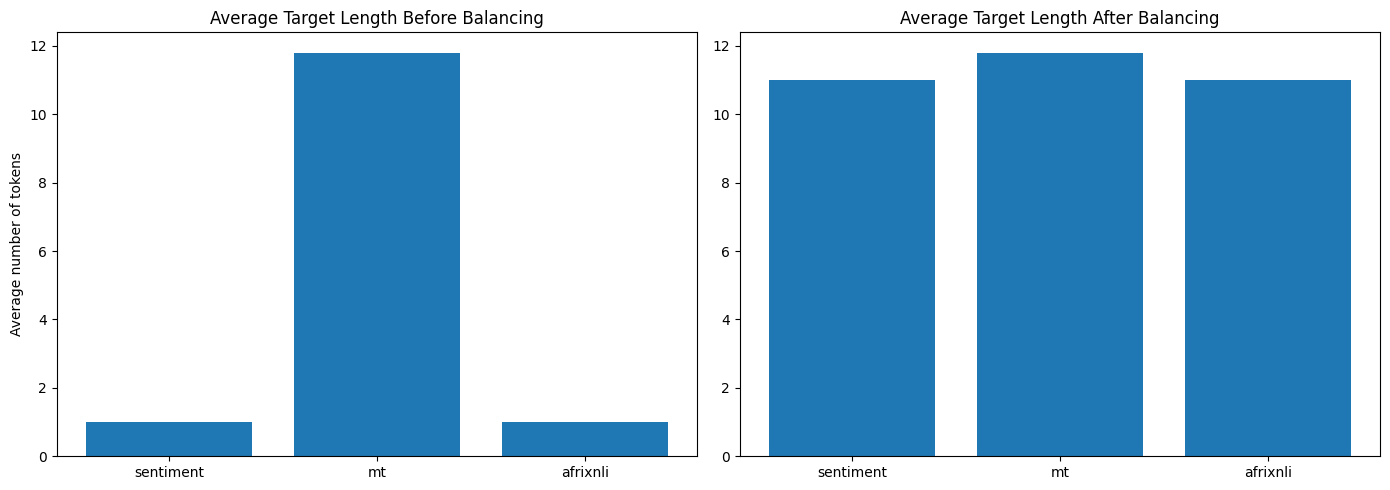

In [ ]:
multitask.plot_target_lengths(train_df, balanced_df)

### Load the Model

In [17]:
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # or load_in_8bit=True for 8-bit quantization
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  # or "fp4"
    bnb_4bit_compute_dtype=torch.bfloat16  # or torch.float16, depending on your hardware
)

In [18]:
print("\n# Setting up model with QLoRA")
model_name = "lelapa/InkubaLM-0.4B"
model, tokenizer, bnb_config = multitask.setup_model_and_tokenizer(model_name)


# Setting up model with QLoRA


tokenizer_config.json:   0%|          | 0.00/960 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/991k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/763 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

## Apply LoRA adapters

In [19]:
model = multitask.apply_lora_adapters(model)

trainable params: 524,288 || all params: 664,684,544 || trainable%: 0.0789


In [20]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
print("\n# Training with unbalanced dataset (demonstrating the problem)")
unbalanced_trainer = multitask.setup_trainer(
    model=model,
    dataset= unbalanced_dataset,
    tokenizer=tokenizer,
    output_dir="./sft_model/unbalanced"
)
unbalanced_trainer.train()


# Training with unbalanced dataset (demonstrating the problem)


Applying formatting function to train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/1400 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,5.196800
20,4.909600
30,4.903700
40,5.611500
50,4.968400
60,5.288400
70,5.330700
80,5.188700
90,4.687600
100,4.530400


TrainOutput(global_step=525, training_loss=4.523114369710286, metrics={'train_runtime': 491.4332, 'train_samples_per_second': 8.546, 'train_steps_per_second': 1.068, 'total_flos': 1930701094256640.0, 'train_loss': 4.523114369710286})

In [21]:
balanced_trainer = multitask.setup_trainer(
    model=model,
    dataset=balanced_dataset,
    tokenizer=tokenizer,
    output_dir="./sft_model/balanced"
)
train_output = balanced_trainer.train()

Applying formatting function to train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/1400 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,3.076800
20,3.292300
30,2.691500
40,3.403400
50,2.422400
60,3.158800
70,2.874300
80,2.508100
90,1.885200
100,2.851200


## Save model in Google Drive

In [22]:
output_dir = "/content/drive/MyDrive/InkubaLM/outputs/lora_checkpoint"

In [23]:
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/MyDrive/InkubaLM/outputs/lora_checkpoint/tokenizer_config.json',
 '/content/drive/MyDrive/InkubaLM/outputs/lora_checkpoint/special_tokens_map.json',
 '/content/drive/MyDrive/InkubaLM/outputs/lora_checkpoint/tokenizer.model',
 '/content/drive/MyDrive/InkubaLM/outputs/lora_checkpoint/added_tokens.json',
 '/content/drive/MyDrive/InkubaLM/outputs/lora_checkpoint/tokenizer.json')

In [24]:
## save the train_output metadata (loss, epochs, etc)
import json
with open(f"{output_dir}/training_output.json", "w") as f:
    json.dump({"training_loss": train_output.training_loss}, f)


## Extract Training Results and Log Experiment

In [ ]:
final_loss = train_output.training_loss

In [ ]:
final_loss

1.8877622858683267

In [ ]:
zindi_score, dict_scores = eval.evaluate_zindi(os.path.join(
    output_path,
    "submission_test.csv")
)

In [ ]:
zindi_score

np.float64(0.2046353846878363)

In [ ]:
experiment_logger.log_experiment_auto(
    trainer=balanced_trainer,
    train_output=train_output,
    prompt_variant="Instruction v3 + few-shot",
    task_metrics=dict_scores,
    lb_score=dict_scores["zindi_score"],
    notes="Added larger rank, new Swahili MT prompt"
)

### Check output

In [ ]:
log_path = "/content/drive/MyDrive/InkubaLM/outputs/experiment_log.csv"
df = pd.read_csv(log_path)
df.head()  # Show first 5 rows


,run_id,date,model_name,prompt_variant,balanced,repetition_factor,epochs,train_loss,sentiment_f1,nli_f1,mt_chrf,zindi_score,notes
0,run_001,2025-03-25,InkubaLM + LoRA (rank=8),Instruction v3 + few-shot,True,11,3,1.888,0.303,0.2222,0.0887,0.2046,Overwritten for new metric format
